In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay, make_scorer)
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pyrcn.echo_state_network import ESNClassifier

from scipy.stats import fisher_exact

from keras.models import Sequential
from keras.layers import LSTM, Dense

import torch

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')

data.head()

,Symbol,Company_Name,Exchange,Orig_Range_Low,Orig_Range_High,Price,Shares,Offer_Amount,ipo_date,IPO_Year,...,plustwo_volume_pct,plusthree_change_pct,plusthree_volume_pct,plus90_change_pct,plus90_volume_pct,plus180_change_pct,plus180_volume_pct,d1_d180,d1_pop,d1_d180_pre_price
0,LXEO,Lexeo Therapeutics,Nasdaq,13.0,15.0,11.0,9090910,100000010,11/3/23,2023,...,0.013554,-0.005607,0.027481,-0.007088,0.008493,-0.010459,0.008693,1,0,1
1,MNR,Mach Resources,NYSE,19.0,21.0,19.0,10000000,190000000,10/25/23,2023,...,0.014016,-0.060652,0.014147,0.015936,0.004482,-0.021266,0.007779,1,0,1
2,BIRK,Birkenstock,NYSE,44.0,49.0,46.0,32258064,1483870944,10/11/23,2023,...,0.000001,0.037633,0.094204,-0.012492,0.017129,-0.002016,0.012965,1,0,0
3,KVYO,Klaviyo,NYSE,25.0,27.0,30.0,19200000,576000000,9/20/23,2023,...,0.093943,0.007383,0.130651,-0.048713,0.053359,0.022050,0.084599,0,1,1
4,CART,Maplebear,Nasdaq,26.0,28.0,30.0,22000000,660000000,9/19/23,2023,...,0.330195,-0.049430,0.202700,0.014551,0.063364,0.039052,0.193695,1,1,1


In [3]:
label_encoder = LabelEncoder()
data['Exchange'] = label_encoder.fit_transform(data['Exchange'])
data['Sector'] = label_encoder.fit_transform(data['Sector'])
data['Industry'] = label_encoder.fit_transform(data['Industry'])

In [4]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_pop', 'd1_d180'])

In [5]:
data.head()

,Exchange,Price,Shares,Offer_Amount,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,Industry,...,market_min5,market_min4,market_min3,market_min2,market_min1,market_min0,sent_negative,sent_neutral,sent_positive,d1_d180_pre_price
0,1,11.0,9090910,100000010,2023,5,-0.153846,-0.266667,5,12,...,13463.77810,14033.09100,13739.49652,13585.84000,13199.42727,13913.16048,0,0,0,1
1,0,19.0,10000000,190000000,2023,8,0.000000,-0.095238,3,63,...,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,15149.39545,0,0,0,1
2,0,46.0,32258064,1483870944,2023,249,0.045455,-0.061224,1,38,...,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,15149.39545,2,1,0,0
3,0,30.0,19200000,576000000,2023,11,0.200000,0.111111,8,79,...,15507.15789,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,1,0,0,1
4,1,30.0,22000000,660000000,2023,11,0.153846,0.071429,1,54,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.84000,1,1,0,1


In [6]:
X = data.drop(columns=['d1_d180_pre_price'])
y = data['d1_d180_pre_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

under_sampler = RandomUnderSampler()

X_train, y_train = under_sampler.fit_resample(X_train, y_train)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

#### Long Short-Term Memory (LSTM):

In [7]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [8]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[1])))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/500
6/6 [==============================] - 1s 37ms/step - loss: 0.6951 - accuracy: 0.5000 - val_loss: 0.6549 - val_accuracy: 0.8362
Epoch 2/500
6/6 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6599 - val_accuracy: 0.8362
Epoch 3/500
6/6 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6660 - val_accuracy: 0.8362
Epoch 4/500
6/6 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6697 - val_accuracy: 0.8362
Epoch 5/500
6/6 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6744 - val_accuracy: 0.8362
Epoch 6/500
6/6 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6794 - val_accuracy: 0.8362
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6835 - val_accuracy: 0.8362
Epoch 8/500
6/6 [=========

In [9]:
_, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Accuracy:", accuracy)

y_pred_probs = model.predict(X_test_reshaped)

y_pred = (y_pred_probs > 0.5).astype(int)

8/8 [==============================] - 0s 551us/step - loss: 0.6912 - accuracy: 0.1810
Accuracy: 0.18103447556495667
8/8 [==============================] - 0s 580us/step


In [10]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 35,   3],
       [187,   7]])

In [11]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.10770783805873685, 1.7707576940754794)
p-value for Odds Ratio: 0.21353466153201847


In [12]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.92      0.27        38
           1       0.70      0.04      0.07       194

    accuracy                           0.18       232
   macro avg       0.43      0.48      0.17       232
weighted avg       0.61      0.18      0.10       232



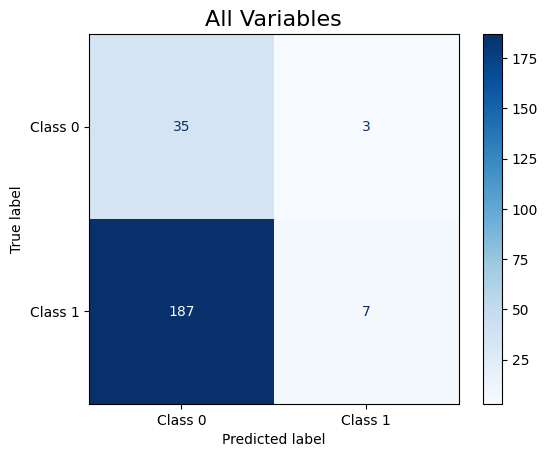

In [13]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lstm_tr.png', dpi=300, bbox_inches="tight")
plt.show()

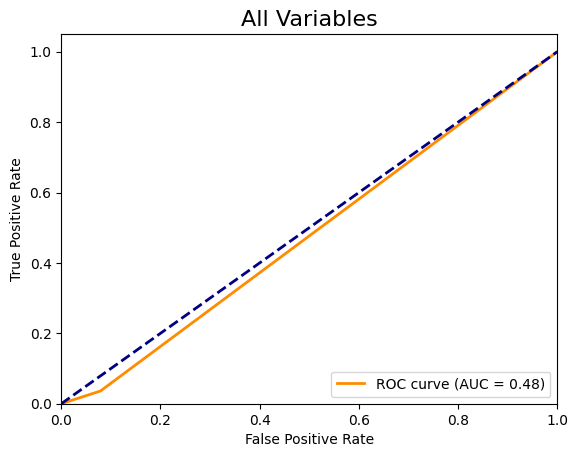

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lstm_tr.png', dpi=300, bbox_inches="tight")
plt.show()

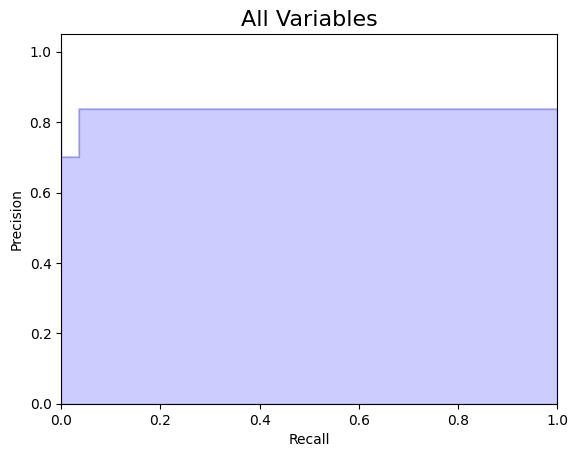

In [15]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lstm_tr.png', dpi=300, bbox_inches="tight")
plt.show()

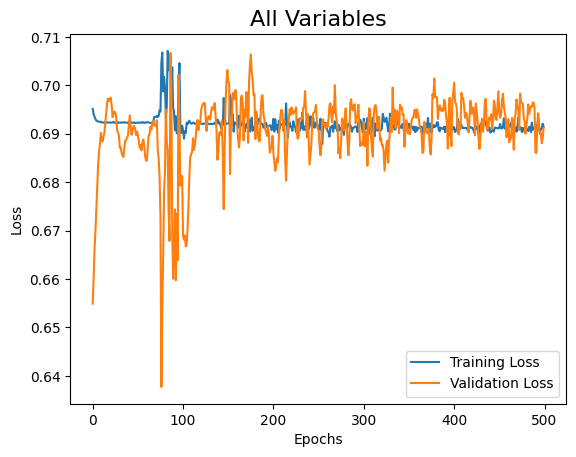

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('All Variables', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochloss_lstm_tr.png', dpi=300, bbox_inches="tight")
plt.show()

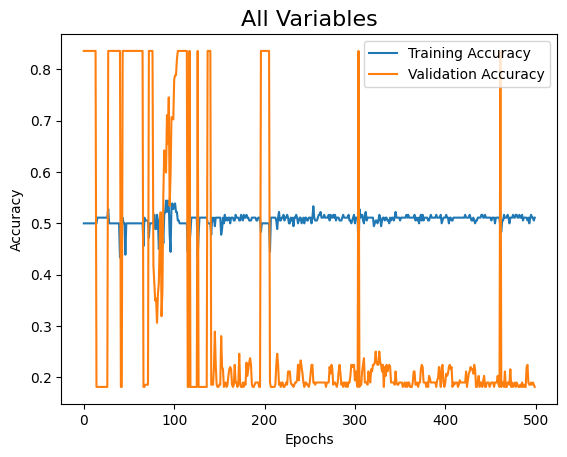

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('All Variables', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochaccuracy_lstm_tr.png', dpi=300, bbox_inches="tight")
plt.show()

## Feature Importance Models

In [18]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [19]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [20]:
fi_data = X[fi]

In [21]:
fi_data.head()

,Price_High_Delta,Price_Low_Delta,raise_to_ipo_ratio,Offer_Amount,Shares,90_Trailing_IPO_plus95,Years_to_IPO,Industry,completed_rounds_to_ipo,Price,...,Corporation,market_min0,Venture_Capital_Round,market_min1,ipo_same_day,number_of_bookrunners,market_min4,market_min5,market_min6,Asset Manager
0,-0.266667,-0.153846,0.337223,100000010,9090910,11,5,12,6,11.0,...,1,13913.16048,3,13199.42727,1,5,14033.09100,13463.77810,12446.53000,2
1,-0.095238,0.000000,1.000000,190000000,10000000,12,8,63,4,19.0,...,0,15149.39545,0,15786.03000,1,5,15560.37143,15230.52727,15507.15789,0
2,-0.061224,0.045455,2.087695,1483870944,32258064,14,249,38,6,46.0,...,0,15149.39545,0,15786.03000,2,11,15560.37143,15230.52727,15507.15789,0
3,0.111111,0.200000,0.514286,576000000,19200000,16,11,79,8,30.0,...,0,15786.03000,5,15980.94783,1,8,15230.52727,15507.15789,15069.23478,6
4,0.071429,0.153846,0.212219,660000000,22000000,15,11,54,17,30.0,...,0,13585.84000,9,13739.49652,1,5,12446.53000,12073.46421,11637.09217,5


In [22]:
X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

under_sampler = RandomUnderSampler()

X_train, y_train = under_sampler.fit_resample(X_train, y_train)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

### LSTM Model

In [23]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [24]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train.shape[1])))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, epochs=500, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/500
6/6 [==============================] - 1s 32ms/step - loss: 0.7056 - accuracy: 0.5000 - val_loss: 0.7818 - val_accuracy: 0.1638
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.5000 - val_loss: 0.7661 - val_accuracy: 0.1638
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 0.7017 - accuracy: 0.5000 - val_loss: 0.7478 - val_accuracy: 0.1638
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.5000 - val_loss: 0.7343 - val_accuracy: 0.1638
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5000 - val_loss: 0.7248 - val_accuracy: 0.2026
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4778 - val_loss: 0.7152 - val_accuracy: 0.6250
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.4722 - val_loss: 0.7111 - val_accuracy: 0.6250
Epoch 8/500
6/6 [=========

In [25]:
_, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Accuracy:", accuracy)

y_pred_probs = model.predict(X_test_reshaped)

y_pred = (y_pred_probs > 0.5).astype(int)

8/8 [==============================] - 0s 611us/step - loss: 0.7049 - accuracy: 0.3750
Accuracy: 0.375
8/8 [==============================] - 0s 520us/step


In [26]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 32,   6],
       [139,  55]])

In [27]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.8358216948453953, 5.328188670123208)
p-value for Odds Ratio: 0.15699651620933833


In [28]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.84      0.31        38
           1       0.90      0.28      0.43       194

    accuracy                           0.38       232
   macro avg       0.54      0.56      0.37       232
weighted avg       0.78      0.38      0.41       232



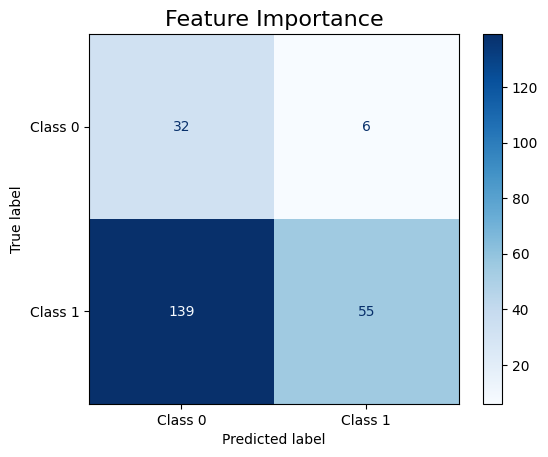

In [29]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_lstm_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

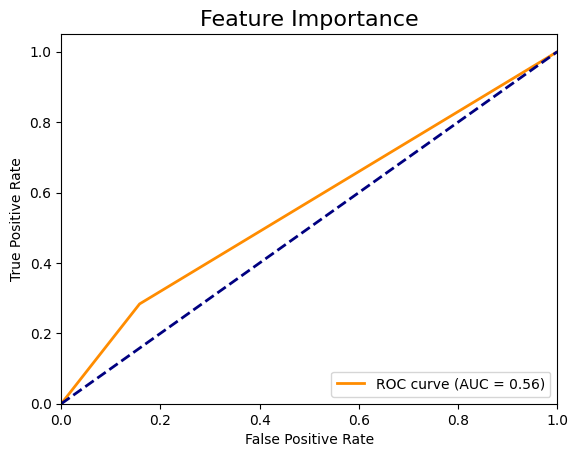

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_lstm_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

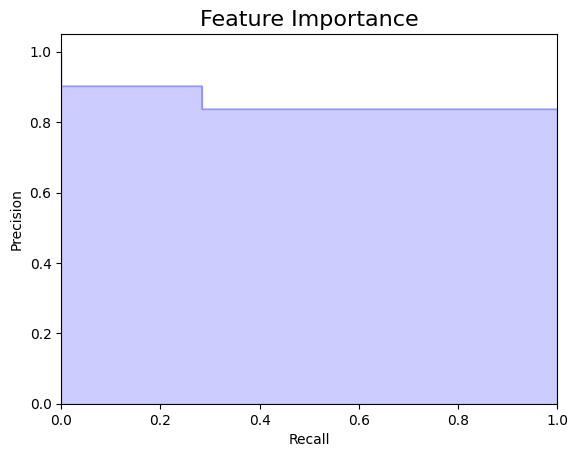

In [31]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_lstm_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

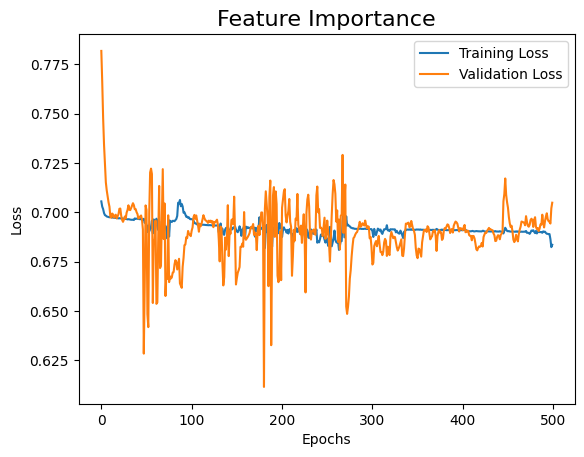

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Feature Importance', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochloss_lstm_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

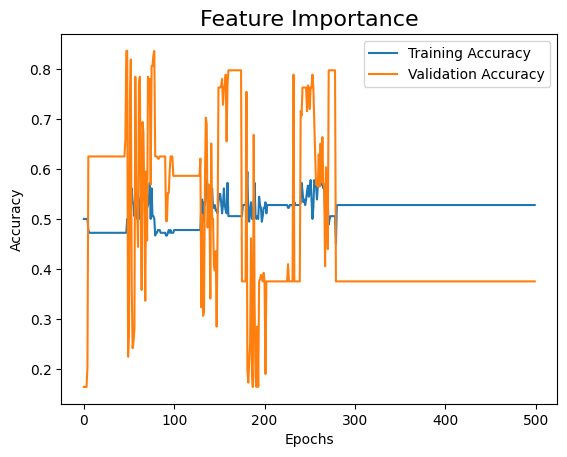

In [33]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Feature Importance', fontsize=16)
plt.legend()
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/epochaccuracy_lstm_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

---
#### End of Notebook